In [1]:
import cv2
import numpy as np
import os
import shutil
from tqdm import tqdm

# --- CRITICAL CONFIGURATION ---
# You MUST adjust this value based on your camera distance!
# Example: If a 10mm tape covers 200 pixels in your image, ratio is 10/200 = 0.05
MM_PER_PIXEL = 0.05  

def sort_cracks_by_mm(input_folder, output_base):
    # Define the new classes based on your screenshot
    # We use 'heavy' instead of 'large' to match your standard
    classes = ['light', 'medium', 'heavy']
    for c in classes:
        os.makedirs(os.path.join(output_base, c), exist_ok=True)
        
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')
    files = [f for f in os.listdir(input_folder) if f.lower().endswith(valid_extensions)]
    
    print(f"Sorting {len(files)} images based on Real-World Width (mm)...")
    print(f"Using conversion: 1 Pixel = {MM_PER_PIXEL} mm")
    
    count_light = 0
    count_medium = 0
    count_heavy = 0
    
    for filename in tqdm(files):
        img_path = os.path.join(input_folder, filename)
        
        # 1. Read Image (Grayscale)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None: continue
        
        # 2. Extract Crack (Thresholding)
        # Inverts image so crack is WHITE, background is BLACK
        # Note: If your preprocessing (Phase 1) was good, cracks are dark.
        _, binary = cv2.threshold(img, 60, 255, cv2.THRESH_BINARY_INV)
        
        # 3. Clean Noise (Morphology)
        # Remove tiny specs that are smaller than a real crack
        kernel = np.ones((3,3), np.uint8)
        cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
        
        # 4. Measure Max Width in Pixels
        dist_transform = cv2.distanceTransform(cleaned, cv2.DIST_L2, 5)
        
        if dist_transform.max() == 0:
            max_width_px = 0
        else:
            # Distance transform gives radius, so * 2 for diameter (width)
            max_width_px = dist_transform.max() * 2 
            
        # 5. Convert to Millimeters
        width_mm = max_width_px * MM_PER_PIXEL
        
        # 6. Apply Your Exact Standards
        if width_mm <= 0.1:
            category = 'light'
            count_light += 1
        elif width_mm <= 0.3:
            # Meaning > 0.1 and <= 0.3
            category = 'medium'
            count_medium += 1
        else:
            # Meaning > 0.3
            category = 'heavy'
            count_heavy += 1
            
        # 7. Move/Copy File
        shutil.copy(img_path, os.path.join(output_base, category, filename))

    print("\n--- Sorting Complete ---")
    print(f"Light  (<= 0.1mm): {count_light}")
    print(f"Medium (0.1-0.3mm): {count_medium}")
    print(f"Heavy  (> 0.3mm):  {count_heavy}")
    print(f"Check folder: {output_base}")

# --- RUN IT ---
# Input: Your folder of standardized/preprocessed patches
input_dir = 'Positive' 
output_dir = 'Crack'

if os.path.exists(input_dir):
    sort_cracks_by_mm(input_dir, output_dir)
else:
    print(f"Error: {input_dir} not found. Please run Phase 1 preprocessing first.")

Sorting 20000 images based on Real-World Width (mm)...
Using conversion: 1 Pixel = 0.05 mm


100%|██████████| 20000/20000 [03:23<00:00, 98.15it/s] 


--- Sorting Complete ---
Light  (<= 0.1mm): 3039
Medium (0.1-0.3mm): 1774
Heavy  (> 0.3mm):  15187
Check folder: Crack


In [2]:
import os
import shutil
import random
from tqdm import tqdm

def undersample_dataset(dataset_path, backup_path):
    """
    Reduces the number of images in larger folders to match the smallest folder.
    Excess images are moved to 'backup_path' (not deleted permanently).
    """
    
    if not os.path.exists(dataset_path):
        print(f"Error: Folder '{dataset_path}' not found.")
        return

    # Create backup folder for the discarded images
    if not os.path.exists(backup_path):
        os.makedirs(backup_path)

    # 1. Identify classes and count images
    classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    class_counts = {}
    file_lists = {}
    
    print("Initial Counts:")
    for cls in classes:
        cls_dir = os.path.join(dataset_path, cls)
        # Get list of valid images
        files = [f for f in os.listdir(cls_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[cls] = len(files)
        file_lists[cls] = files
        print(f"  - {cls}: {len(files)}")
        
    # Find the target number (the size of the SMALLEST folder)
    target_count = min(class_counts.values())
    print(f"\nTarget count (Smallest Class): {target_count}")
    print(f"All folders will be reduced to {target_count} images.")
    
    # 2. Undersample larger classes
    for cls in classes:
        current_count = class_counts[cls]
        
        if current_count <= target_count:
            print(f"Skipping '{cls}' (already at minimum size).")
            continue
            
        diff = current_count - target_count
        print(f"Downsampling '{cls}': Removing {diff} images...")
        
        # Create a specific backup folder for this class
        cls_backup_dir = os.path.join(backup_path, cls)
        os.makedirs(cls_backup_dir, exist_ok=True)
        
        # Randomly choose files to REMOVE
        # We assume the files we KEEP are random, so we pick 'diff' files to move away
        files_to_remove = random.sample(file_lists[cls], diff)
        
        for filename in tqdm(files_to_remove, desc=f"Moving {cls}"):
            src = os.path.join(dataset_path, cls, filename)
            dst = os.path.join(cls_backup_dir, filename)
            
            # Move the file out of the training set
            shutil.move(src, dst)
            
    print(f"\nSuccess! Dataset balanced. Unused images moved to '{backup_path}'.")

# --- CONFIGURATION ---
input_dir = 'Crack'    # Your sorted dataset
unused_dir = 'dataset_unused_data' # Where extra images go (Safe storage)

undersample_dataset(input_dir, unused_dir)

Initial Counts:
  - heavy: 15187
  - light: 3039
  - medium: 1774
  - No Crack: 20000

Target count (Smallest Class): 1774
All folders will be reduced to 1774 images.
Downsampling 'heavy': Removing 13413 images...


Moving heavy: 100%|██████████| 13413/13413 [00:13<00:00, 1000.98it/s]


Downsampling 'light': Removing 1265 images...


Moving light: 100%|██████████| 1265/1265 [00:01<00:00, 1244.77it/s]


Skipping 'medium' (already at minimum size).
Downsampling 'No Crack': Removing 18226 images...


Moving No Crack: 100%|██████████| 18226/18226 [00:13<00:00, 1393.11it/s]


Success! Dataset balanced. Unused images moved to 'dataset_unused_data'.


In [3]:
import os
import shutil
import random
from tqdm import tqdm

def split_dataset(input_folder, output_folder, split_ratios=(0.7, 0.2, 0.1)):
    """
    Splits a sorted dataset into Train, Validation, and Test sets.
    
    input_folder:  Path to folder containing 'light', 'medium', 'large'
    output_folder: Path where 'train', 'val', 'test' folders will be created
    split_ratios:  (Train%, Val%, Test%) - must sum to 1.0
    """
    
    if sum(split_ratios) != 1.0:
        print("Error: Split ratios must sum to 1.0 (e.g., 0.7 + 0.2 + 0.1)")
        return

    # Define the classes based on what's in the input folder
    classes = [d for d in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, d))]
    
    print(f"Found classes: {classes}")
    
    # Create the output directories
    for split in ['train', 'val', 'test']:
        for cls in classes:
            os.makedirs(os.path.join(output_folder, split, cls), exist_ok=True)
            
    # Process each class
    for cls in classes:
        cls_dir = os.path.join(input_folder, cls)
        images = [f for f in os.listdir(cls_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Shuffle randomly so the split isn't biased
        random.shuffle(images)
        
        # Calculate split indices
        n_total = len(images)
        n_train = int(n_total * split_ratios[0])
        n_val = int(n_total * split_ratios[1])
        # The rest goes to test
        
        train_imgs = images[:n_train]
        val_imgs = images[n_train:n_train + n_val]
        test_imgs = images[n_train + n_val:]
        
        print(f"Class '{cls}': {len(train_imgs)} Train, {len(val_imgs)} Val, {len(test_imgs)} Test")
        
        # Helper function to copy files
        def copy_files(file_list, destination_split):
            for filename in file_list:
                src = os.path.join(cls_dir, filename)
                dst = os.path.join(output_folder, destination_split, cls, filename)
                shutil.copy(src, dst)

        # Execute copies
        copy_files(train_imgs, 'train')
        copy_files(val_imgs, 'val')
        copy_files(test_imgs, 'test')

    print(f"\nSuccess! Dataset split created in: {output_folder}")

# --- CONFIGURATION ---
# The folder created by the Auto-Sorter (contains light/medium/large)
source_data_dir = 'Crack' 

# The NEW folder that will contain train/val/test
final_data_dir = 'dataset_final'

# Run the split
if os.path.exists(source_data_dir):
    split_dataset(source_data_dir, final_data_dir)
else:
    print(f"Could not find '{source_data_dir}'. Did you run the Auto-Sorter?")

Found classes: ['heavy', 'light', 'medium', 'No Crack']
Class 'heavy': 1241 Train, 354 Val, 179 Test
Class 'light': 1241 Train, 354 Val, 179 Test
Class 'medium': 1241 Train, 354 Val, 179 Test
Class 'No Crack': 1241 Train, 354 Val, 179 Test

Success! Dataset split created in: dataset_final


In [4]:
import os
import time
import copy
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.ops import deform_conv2d
import timm
from tqdm import tqdm

# ==========================================
#               CONFIGURATION
# ==========================================
CONFIG = {
    'model_name': 'eva02_tiny_patch14_224.mim_in22k', # Pretrained ViT
    'img_size': 224,
    'batch_size': 32,
    'epochs': 15,
    'lr': 1e-4,
    'weight_decay': 0.01,
    'patience': 5,
    'num_classes': 4, # Kaggle usually: Glioma, Meningioma, Pituitary, NoTumor
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'data_dir': 'dataset_final/',  # <--- UPDATE THIS PATH
    'checkpoint_path': 'hybrid_eva02_dcnn_best.pth',
    'seed': 42,
}

# ==========================================
#           1. UTILITIES & DATA
# ==========================================
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def get_dataloaders(data_dir):
    transform = transforms.Compose([
        transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # --- CORRECTED LOADING LOGIC ---
    # We point ImageFolder specifically to the 'train' and 'val' subfolders
    train_dir = os.path.join(data_dir, 'train')
    val_dir = os.path.join(data_dir, 'val')

    if not os.path.exists(train_dir):
        print(f"ERROR: Training folder not found at {train_dir}")
        exit()

    # Load datasets directly from their respective folders
    # No random_split needed because files are already physically separated
    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2, pin_memory=True)
    
    print(f"Correct Classes Found: {train_dataset.classes}")
    print(f"Train Images: {len(train_dataset)} | Val Images: {len(val_dataset)}")
    
    return train_loader, val_loader

# ==========================================
#        2. ARCHITECTURE COMPONENTS
# ==========================================

class LocalCNNBranch(nn.Module):
    """
    A lightweight CNN to extract local textures/edges.
    Downsamples 224x224 -> 16x16 to match the ViT patch grid.
    """
    def __init__(self, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            # 224 -> 112
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # 112 -> 56
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # 56 -> 28
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # 28 -> 14 (Matches Eva02 patch grid 224/16 = 14)
            nn.Conv2d(256, out_dim, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_dim),
            nn.SiLU()
        )

    def forward(self, x):
        return self.net(x)

class CrossAttentionFusion(nn.Module):
    """
    Fuses Local CNN features (Query) with Global ViT features (Key/Value).
    Handles different sequence lengths between CNN and ViT.
    """
    def __init__(self, dim, num_heads=4, qkv_bias=False):
        super().__init__()
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5

        self.q_proj = nn.Linear(dim, dim, bias=qkv_bias) # For CNN
        self.k_proj = nn.Linear(dim, dim, bias=qkv_bias) # For ViT
        self.v_proj = nn.Linear(dim, dim, bias=qkv_bias) # For ViT

        self.proj = nn.Linear(dim, dim)
        self.norm = nn.LayerNorm(dim)

    def forward(self, x_local, x_global):
        # x_local: [Batch, Channels, H, W] (CNN Feature Map)
        B, C, H, W = x_local.shape
        # Flatten CNN to [Batch, N_local, C] -> This is our Query length
        x_local_flat = x_local.flatten(2).transpose(1, 2) 
        
        # x_global: [Batch, N_vit, C] (ViT Tokens) -> This is our Key/Value length
        B_v, N_vit, C_v = x_global.shape

        # --- Projections ---
        # 1. Query (CNN): Uses H*W (196)
        q = self.q_proj(x_local_flat).reshape(B, H*W, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
        
        # 2. Key & Value (ViT): Uses N_vit (256) 
        # (This was the cause of the error; we now use N_vit instead of H*W)
        k = self.k_proj(x_global).reshape(B, N_vit, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
        v = self.v_proj(x_global).reshape(B, N_vit, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)

        # --- Attention ---
        # Matrix multiplication: (Q @ K.T)
        # Shape: [Batch, Heads, 196, 256] -> Maps 256 ViT tokens to 196 CNN locations
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)

        # --- Weighted Sum ---
        # (Attn @ V) -> Shape: [Batch, Heads, 196, Head_Dim]
        x = (attn @ v).transpose(1, 2).reshape(B, H*W, C)
        
        # Project back
        x = self.proj(x)
        
        # Residual + Norm
        x = self.norm(x + x_local_flat)
        
        # Reshape back to CNN spatial dimensions [Batch, C, 14, 14]
        return x.transpose(1, 2).reshape(B, C, H, W)

class DeformableDCNNHead(nn.Module):
    """
    Applies Deformable Convolution to handle irregular tumor boundaries.
    """
    def __init__(self, dim, num_classes):
        super().__init__()
        
        # Offset predictor: learns WHERE to look
        self.offset_conv = nn.Conv2d(dim, 2 * 3 * 3, kernel_size=3, padding=1)
        
        # The actual weights for the convolution
        self.deform_weight = nn.Parameter(torch.Tensor(dim, dim, 3, 3))
        nn.init.kaiming_uniform_(self.deform_weight, nonlinearity='relu')
        
        self.bn = nn.BatchNorm2d(dim)
        self.act = nn.GELU()
        
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(dim, num_classes)

    def forward(self, x):
        # x shape: [Batch, Dim, 14, 14]
        
        # 1. Predict Offsets
        offsets = self.offset_conv(x)
        
        # 2. Apply Deformable Conv
        x = deform_conv2d(x, offsets, self.deform_weight, padding=1)
        x = self.act(self.bn(x))
        
        # 3. Classify
        x = self.global_pool(x).flatten(1)
        logits = self.classifier(x)
        return logits

# ==========================================
#           3. THE HYBRID MODEL
# ==========================================
class HybridEva02_DCNN(nn.Module):
    def __init__(self, model_name, num_classes, pretrained=True):
        super().__init__()
        
        # --- Branch A: Eva-02 Transformer ---
        self.vit = timm.create_model(model_name, pretrained=pretrained, num_classes=0)
        self.embed_dim = self.vit.num_features 
        
        # --- Branch B: Local CNN ---
        self.cnn = LocalCNNBranch(out_dim=self.embed_dim)
        
        # --- Fusion: Cross Attention ---
        self.fusion = CrossAttentionFusion(dim=self.embed_dim)
        
        # --- Head: Deformable CNN ---
        self.head = DeformableDCNNHead(dim=self.embed_dim, num_classes=num_classes)

    def forward(self, x):
        # 1. Global Features (ViT)
        # forward_features returns [Batch, 1+256, Dim]. 
        # We slice [:, 1:, :] to remove the class token. 
        # Result: [Batch, 256, Dim]
        x_vit = self.vit.forward_features(x)[:, 1:, :] 
        
        # 2. Local Features (CNN)
        # Result: [Batch, Dim, 14, 14]
        x_cnn = self.cnn(x) 
        
        # 3. Cross Attention Fusion
        # Now handles the 256 vs 196 mismatch automatically
        x_fused = self.fusion(x_local=x_cnn, x_global=x_vit)
        
        # 4. Deformable Classification
        logits = self.head(x_fused)
        
        return logits

# ==========================================
#             4. TRAINING LOOP
# ==========================================
def train_engine():
    seed_everything(CONFIG['seed'])
    
    # Init Data and Model
    print("Initializing Data Loaders...")
    train_loader, val_loader = get_dataloaders(CONFIG['data_dir'])
    
    print(f"Initializing Hybrid Model ({CONFIG['model_name']})...")
    model = HybridEva02_DCNN(CONFIG['model_name'], CONFIG['num_classes']).to(CONFIG['device'])
    
    # Optimization
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)
    
    best_acc = 0.0
    
    print("Starting Training...")
    for epoch in range(CONFIG['epochs']):
        # --- TRAIN ---
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']} [Train]")
        for inputs, labels in pbar:
            inputs, labels = inputs.to(CONFIG['device']), labels.to(CONFIG['device'])
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient Clipping (Stability for Transformers)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({'loss': running_loss/total, 'acc': correct/total})
            
        train_acc = correct / total
        
        # --- VALIDATION ---
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0.0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(CONFIG['device']), labels.to(CONFIG['device'])
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
                
        val_acc = val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)
        
        print(f"Epoch {epoch+1} Result: Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val Loss: {avg_val_loss:.4f}")
        
        scheduler.step(val_acc)
        
        # Save Best
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), CONFIG['checkpoint_path'])
            print(f"--> New Best Model Saved! ({best_acc:.4f})")
            
    print(f"\nTraining Complete. Best Validation Accuracy: {best_acc:.4f}")

if __name__ == "__main__":
    train_engine()

Initializing Data Loaders...
Correct Classes Found: ['No Crack', 'heavy', 'light', 'medium']
Train Images: 4964 | Val Images: 1416
Initializing Hybrid Model (eva02_tiny_patch14_224.mim_in22k)...
Starting Training...


Epoch 1/15 [Train]: 100%|██████████| 156/156 [00:35<00:00,  4.44it/s, loss=0.0143, acc=0.829]


Epoch 1 Result: Train Acc: 0.8288 | Val Acc: 0.8792 | Val Loss: 0.3070
--> New Best Model Saved! (0.8792)


Epoch 2/15 [Train]: 100%|██████████| 156/156 [00:35<00:00,  4.45it/s, loss=0.00917, acc=0.894]


Epoch 2 Result: Train Acc: 0.8936 | Val Acc: 0.9040 | Val Loss: 0.2716
--> New Best Model Saved! (0.9040)


Epoch 3/15 [Train]: 100%|██████████| 156/156 [00:35<00:00,  4.44it/s, loss=0.00801, acc=0.906]


Epoch 3 Result: Train Acc: 0.9061 | Val Acc: 0.9075 | Val Loss: 0.2545
--> New Best Model Saved! (0.9075)


Epoch 4/15 [Train]: 100%|██████████| 156/156 [00:34<00:00,  4.47it/s, loss=0.00629, acc=0.929]


Epoch 4 Result: Train Acc: 0.9289 | Val Acc: 0.9174 | Val Loss: 0.2513
--> New Best Model Saved! (0.9174)


Epoch 5/15 [Train]: 100%|██████████| 156/156 [00:35<00:00,  4.43it/s, loss=0.0062, acc=0.935] 


Epoch 5 Result: Train Acc: 0.9347 | Val Acc: 0.9131 | Val Loss: 0.2439


Epoch 6/15 [Train]: 100%|██████████| 156/156 [00:34<00:00,  4.48it/s, loss=0.00614, acc=0.932]


Epoch 6 Result: Train Acc: 0.9317 | Val Acc: 0.8390 | Val Loss: 0.4803


Epoch 7/15 [Train]: 100%|██████████| 156/156 [00:33<00:00,  4.60it/s, loss=0.00458, acc=0.955]


Epoch 7 Result: Train Acc: 0.9555 | Val Acc: 0.9047 | Val Loss: 0.3154


Epoch 8/15 [Train]: 100%|██████████| 156/156 [00:34<00:00,  4.57it/s, loss=0.00306, acc=0.973]


Epoch 8 Result: Train Acc: 0.9730 | Val Acc: 0.8771 | Val Loss: 0.4993


Epoch 9/15 [Train]: 100%|██████████| 156/156 [00:34<00:00,  4.53it/s, loss=0.00289, acc=0.978]


Epoch 9 Result: Train Acc: 0.9778 | Val Acc: 0.9188 | Val Loss: 0.3303
--> New Best Model Saved! (0.9188)


Epoch 10/15 [Train]: 100%|██████████| 156/156 [00:36<00:00,  4.27it/s, loss=0.00196, acc=0.986]


Epoch 10 Result: Train Acc: 0.9863 | Val Acc: 0.9230 | Val Loss: 0.3328
--> New Best Model Saved! (0.9230)


Epoch 11/15 [Train]: 100%|██████████| 156/156 [00:35<00:00,  4.46it/s, loss=0.00163, acc=0.988]


Epoch 11 Result: Train Acc: 0.9883 | Val Acc: 0.9280 | Val Loss: 0.3687
--> New Best Model Saved! (0.9280)


Epoch 12/15 [Train]: 100%|██████████| 156/156 [00:34<00:00,  4.50it/s, loss=0.00135, acc=0.99]  


Epoch 12 Result: Train Acc: 0.9901 | Val Acc: 0.9258 | Val Loss: 0.4137


Epoch 13/15 [Train]: 100%|██████████| 156/156 [00:34<00:00,  4.54it/s, loss=0.00123, acc=0.991]


Epoch 13 Result: Train Acc: 0.9913 | Val Acc: 0.9287 | Val Loss: 0.3898
--> New Best Model Saved! (0.9287)


Epoch 14/15 [Train]: 100%|██████████| 156/156 [00:33<00:00,  4.61it/s, loss=0.00133, acc=0.99] 


Epoch 14 Result: Train Acc: 0.9897 | Val Acc: 0.9237 | Val Loss: 0.3803


Epoch 15/15 [Train]: 100%|██████████| 156/156 [00:33<00:00,  4.60it/s, loss=0.00124, acc=0.992]


Epoch 15 Result: Train Acc: 0.9921 | Val Acc: 0.9301 | Val Loss: 0.3625
--> New Best Model Saved! (0.9301)

Training Complete. Best Validation Accuracy: 0.9301


Test Classes: ['No Crack', 'heavy', 'light', 'medium']
Test Images: 716

Running Test Evaluation...

 Test Accuracy: 0.9176
 Test Loss:     0.4371

Classification Report:
              precision    recall  f1-score   support

    No Crack       1.00      1.00      1.00       179
       heavy       0.98      0.91      0.94       179
       light       0.90      0.88      0.89       179
      medium       0.81      0.88      0.84       179

    accuracy                           0.92       716
   macro avg       0.92      0.92      0.92       716
weighted avg       0.92      0.92      0.92       716

Confusion Matrix:
[[179   0   0   0]
 [  0 163   0  16]
 [  0   0 158  21]
 [  0   4  18 157]]


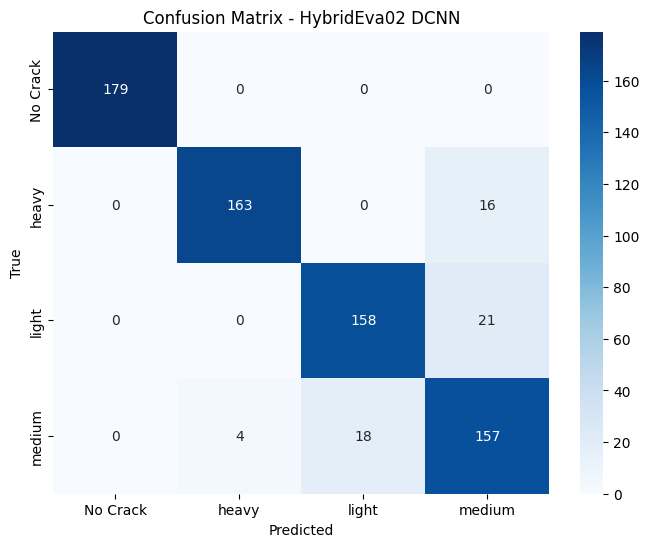

In [5]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# Load Test Data
# -----------------------------
def get_test_loader(test_dir, img_size=224, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    
    test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"Test Classes: {test_dataset.classes}")
    print(f"Test Images: {len(test_dataset)}")

    return test_loader, test_dataset.classes


# ------------------------------------------
# Load Model & Evaluate on Test Set
# ------------------------------------------
def test_model():
    device = CONFIG["device"]

    # Load Test Loader
    test_dir = os.path.join(CONFIG["data_dir"], "test")
    test_loader, class_names = get_test_loader(test_dir, CONFIG["img_size"], CONFIG["batch_size"])

    # Load Model
    model = HybridEva02_DCNN(CONFIG['model_name'], CONFIG['num_classes'])
    model.load_state_dict(torch.load(CONFIG["checkpoint_path"], map_location=device))
    model.to(device)
    model.eval()

    criterion = nn.CrossEntropyLoss()

    total = 0
    correct = 0
    total_loss = 0.0

    all_labels = []
    all_preds = []

    print("\nRunning Test Evaluation...")

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    test_acc = correct / total
    avg_loss = total_loss / len(test_loader)

    print(f"\n===============================")
    print(f" Test Accuracy: {test_acc:.4f}")
    print(f" Test Loss:     {avg_loss:.4f}")
    print("===============================\n")

    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    # ------------------------------------
    # 📌 Seaborn Heatmap Confusion Matrix
    # ------------------------------------
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm,
                annot=True,
                fmt="d",
                cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - HybridEva02 DCNN")
    plt.show()


# Run Test
test_model()
